# Propeller identification
We want to charchterize the transfer function of a drone propeller (BLDC motor) by measuring a set of datapoints and applying machine learning techniques to approximate the parameters

## Collection of the data points
We collect data by interfacing the computer and the board via a serial port.
In the PC side we use the pySerial library

In [1]:
import serial   # pip install pyserial, not pip install serial !

# Serial port parameters
port = '/dev/ttyUSB0'   # Depends on the OS
baud = 9600
timeout = 3

# Open te serial port
ser = serial.Serial(port, baud, timeout=timeout)
ser.flush()

We now define two function to simplify reading and writing data via the serial port.
Note that this is specific to this particular setup.

In [2]:
# Returns a string, already decoded and polished
def my_readline():
    line = ser.readline().decode('UTF-8').strip()
    return line

# Writes a message, following the protocol we defined:
# <message>
def my_write(message):
    ser.write(("<"+message+">").encode())

To get the data, we first must send a message to the board to tell how to measure. We have to send:
- the command: what we want to do
- the step: the distance between each input value. Can be negative
- the max pwm value to test
- the number of samples per input value

After that, the board will start the test and will send back data, line by line.
Each line sent by the board is a sample, already formatted to be written in a .csv file.
While we read the data, we also write it into a .csv file to store all the samples.

In [3]:
import csv

# Given the parameters, build the message string
def build_message(command, n_samples, step, max_pwm):
    # The words are separated by a space
    message = " ".join([command, str(n_samples), str(step), str(max_pwm)])
    return message

def build_message(list_of_string):
    message = " ".join(list_of_string)
    return message

# Given a message and a filename, send the message and store the data in the specified file
def get_dataset(message, filename):
    ser.flush()
    # Open the file
    file = open(filename, 'a')
    file.truncate(0)

    # Setup the csv
    csv_writer = csv.writer(file)

    # Send the command to get the measurements
    my_write(message)

    # Listen to the response
    while 1:
        # Read a line = a row of the matrix S = a sample
        line = my_readline()

        # Check if the line is empty => skip
        if line == '':
            continue

        # If there is something, I check if it is the termination message
        if line == "Finished":
            file.close()
            print("Finished")
            break

        # Forced stop
        if line == 'STOP':
            file.close()
            print("Stopped")
            break

        # Exception unhandled
        if line == 'Arduino is ready':
            print("Exception occured")
            break

        # If I'm here it is a proper sample
        print(line)
        values = line.split(',')
        if 'Message' in values[0]:
            continue
        
        csv_writer.writerow(values)

Finally we can collect the data

In [5]:
# Collect the data for the ramp
command = 'R'   # Measure
n_samples = 10  # How many samples do I want to average for each input value
step = 5      # Step for the input signal
min_pwm = 1180   # Start from here
max_pwm = 1400 # Max value to test
filename = "Dataset_ramp.csv"

In [ ]:
ser = serial.Serial(port, baud, timeout=timeout)
get_dataset(build_message([command, str(n_samples), str(step), str(min_pwm), str(max_pwm)]), filename)

## Plot
After collecting the data, we draw a beautiful plot.

Before actually drawing the plot, we have to get the data from the file we created

In [4]:
import pandas
data_frame = pandas.read_csv(filename)
print(data_frame.tail())

NameError: name 'filename' is not defined

In [5]:
# https://matplotlib.org/stable/tutorials/introductory/quick_start.html#sphx-glr-tutorials-introductory-quick-start-py
import matplotlib as mpl
import matplotlib.pyplot as plt

data_frame.plot(x='PWM', y='RPM', kind='scatter', s=3, c='blue')
data_frame.plot(x='PWM', y='Thrust', kind='scatter', s=3, c='red')
data_frame.plot(x='RPM', y='Thrust', kind='scatter', s=3, c='red')

NameError: name 'data_frame' is not defined

## Step response
Now we measure the step response of the propeller.

The value at which we measure it coincides with the chosen operating point in the final system.

Additionally, we indicate to the board which interval to measure.

In [6]:
command = 'S'
step_value = 1500
n_samples = 1000
max_time = 2000    # milliseconds
filename = 'Dataset_step.csv'

In [128]:
ser = serial.Serial(port, baud, timeout=timeout)
get_dataset(build_message([command, str(step_value), str(max_time)]), filename)

Message received: S 1500 2000. Response: Command: S, Step: 0, max_time: 0
T,RPM
0,0
227, 263.736
262, 1709.889
290, 2158.584
314, 2533.677
337, 2545.717
360, 2673.439
382, 2652.168
404, 2770.467
426, 2738.476
447, 2851.304
468, 2809.515
489, 2915.735
510, 2869.578
530, 2973.241
550, 2919.992
570, 3020.996
590, 2963.988
610, 3062.474
630, 3000.600
649, 3096.934
669, 3032.907
688, 3128.259
708, 3061.537
727, 3155.570
746, 3086.102
765, 3179.145
785, 3107.520
803, 3198.976
823, 3125.000
841, 3215.951
860, 3142.842
879, 3233.804
898, 3156.898
916, 3245.699
935, 3167.062
954, 3255.915
973, 3177.461
991, 3264.063
1010, 3186.066
1028, 3275.109
1047, 3197.272
1065, 3284.432
1084, 3200.854
1102, 3287.671
1121, 3221.996
1139, 3317.300
1157, 3235.024
1176, 3319.869
1194, 3237.818
1212, 3323.916
1231, 3238.866
1249, 3323.363
1267, 3237.992
1285, 3322.259
1304, 3239.566
1322, 3323.363
1340, 3240.091
1358, 3325.205
1377, 3242.367
1395, 3327.418
1413, 3242.192
1432, 3326.496
1450, 3244.120
1468, 3330

        T        RPM
462  3975  11871.785
463  3980  11670.881
464  3985  11867.089
465  3990  11675.423
466  3995  11869.437


<Axes: xlabel='T'>

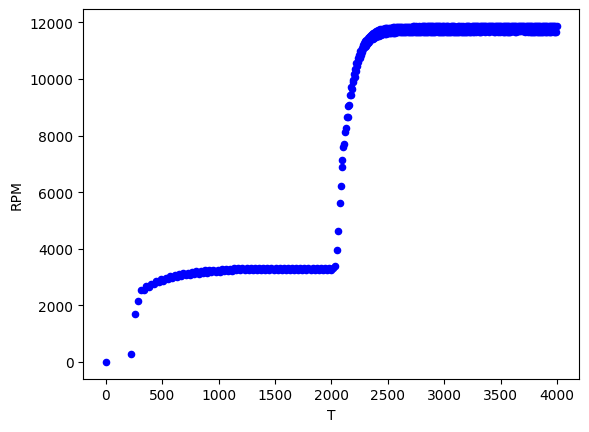

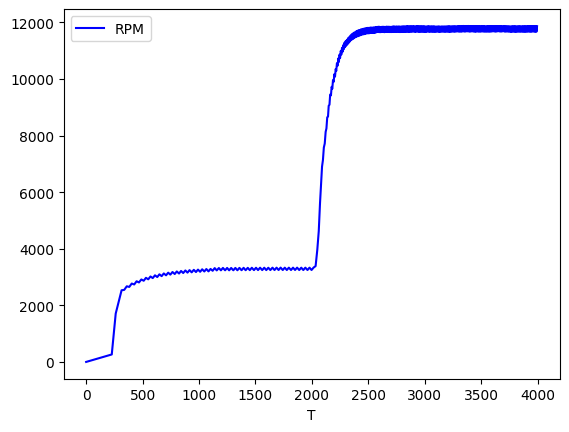

In [129]:
data_frame_step = pandas.read_csv(filename)
print(data_frame_step.tail())
data_frame_step.plot(x='T', y='RPM', kind='scatter', c='blue')
data_frame_step.plot(x='T', y='RPM', kind='line', c='blue')

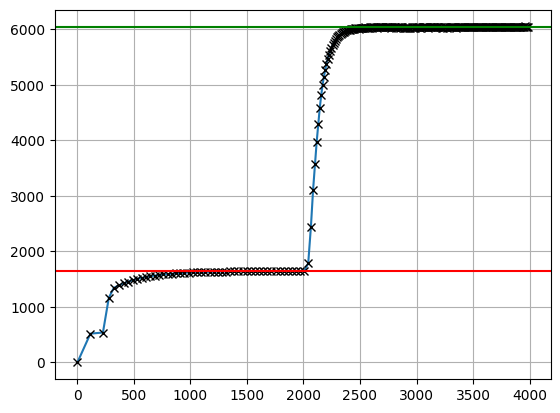

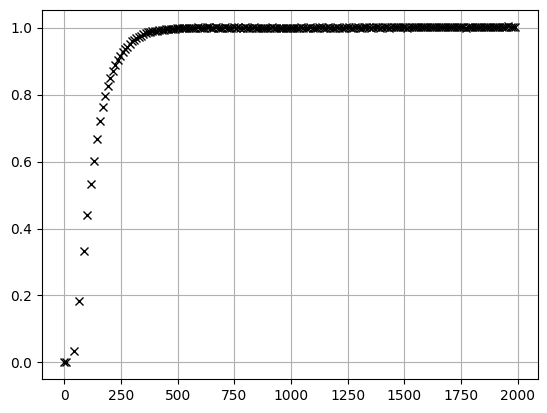

In [36]:
fig, ax = plt.subplots()
ax.grid(True)
ax.plot(data_frame_step['T'], data_frame_step['RPM'])
ax.plot(data_frame_step['T'], data_frame_step['RPM'], 'kx')

baseline = data_frame_step[ (data_frame_step['T'] > 1000) & (data_frame_step['T'] < 2000) ]
baseline_rpm = baseline['RPM'].mean()
ax.axhline(baseline_rpm, color='r')

step_df = data_frame_step[ (data_frame_step['T'] > 2000) & (data_frame_step['T'] < 4000)]
step_ss_df = data_frame_step[ (data_frame_step['T'] > 3000) & (data_frame_step['T'] < 3500) ]
ss_rpm = step_ss_df['RPM'].mean()
ax.axhline(ss_rpm, color='g')

step_normalized = step_df.copy()
step_normalized['T'] = step_normalized['T'] - 2000
step_normalized['RPM'] = (step_normalized['RPM'] - baseline_rpm) / (ss_rpm - baseline_rpm)
#step_normalized = step_normalized[ step_normalized['RPM'] < 0.99]
new_row = pandas.DataFrame({'T':0, 'RPM':0}, index=[0])
step_normalized = pandas.concat([new_row, step_normalized[:]]).reset_index(drop = True)

fig, ax = plt.subplots()
ax.plot(step_normalized['T'], step_normalized['RPM'], 'kx');
ax.grid(True)

### Non linear regression

/tmp/ipykernel_14265/2745878954.py:5: RuntimeWarning: invalid value encountered in log
  step_normalized['RPM_P'] = step_normalized.apply( lambda row : np.log( 1 - row.RPM ), axis = 1 )


ValueError: Input y contains NaN.

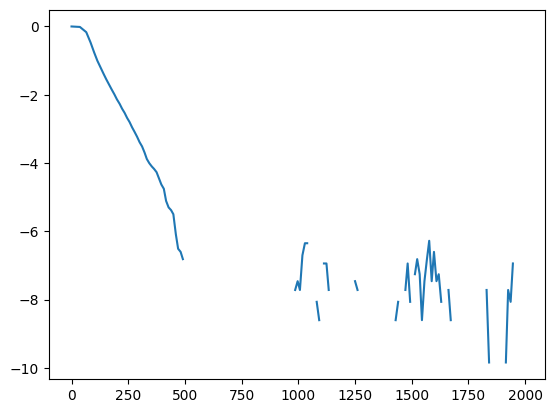

In [45]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Compute the natural logarithm of the rpm
step_normalized['RPM_P'] = step_normalized.apply( lambda row : np.log( 1 - row.RPM ), axis = 1 )

fig, ax = plt.subplots()
ax.plot(step_normalized['T'], step_normalized['RPM_P'])

X = step_normalized['T'].to_numpy().reshape(-1,1)
Y = step_normalized['RPM_P'].to_numpy()

reg = LinearRegression().fit(X,Y)
prediction = reg.predict(X)

ax.plot(X, prediction)

fig, ax = plt.subplots()
ax.plot(step_normalized['T'], step_normalized['RPM'])
ax.plot(X, 1 - np.exp(prediction))

tau1 = -0.01
wn = 0.01

t = np.arange(0, 400, 1)
ax.plot(t, 1 - np.multiply( np.exp(tau1*t), np.cos(wn*t) ))

In [7]:
command = 'S'
step_value = 1500
max_time = 2000    # milliseconds
N = 5

for i in range(1,1+N):
    filename = "Dataset_step_" + str(i) + ".csv"
    get_dataset(build_message([command, str(step_value), str(max_time)]), filename)

Message received: S 1500 2000. Response: Command: S, Step: 0, max_time: 0
T,RPM
0,0
Finished
Message received: S 1500 2000. Response: Command: S, Step: 0, max_time: 0
T,RPM
0,0
Finished
Message received: S 1500 2000. Response: Command: S, Step: 0, max_time: 0


KeyboardInterrupt: 

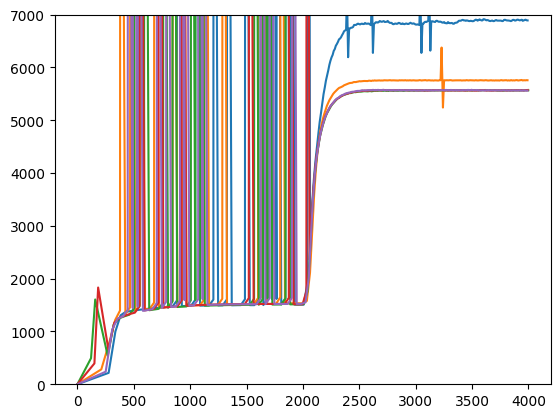

In [21]:
fig, ax = plt.subplots()

for i in range(1,1+N):
    filename = "Dataset_step_" + str(i) + ".csv"
    data_frame_step = pandas.read_csv(filename)

    ax.plot(data_frame_step['T'], data_frame_step['RPM'])
    ax.set_ylim(0, 7000)


# Identification
See appendx W3.7.3 in "Feedback Control of Dynamical Systems"

## Model
We assume the step response is made of a sum of a static value y(inf) and a series of exponential signals, each with its own gain and time constant
$$ y(t) = y(\infty) + Ae^{-\alpha t} + Be^{-\beta t} + ...$$

## Identification process
We iteratively remove the slowest component.

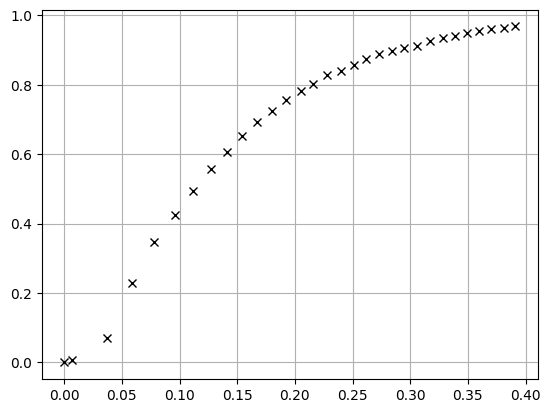

In [147]:
# Load the data
filename = "Dataset_step copy.csv"
data_frame_step = pandas.read_csv(filename)

# Process the raw data

# Remove the first part of the signal (we dont need it)
baseline = data_frame_step[ (data_frame_step['T'] > 1000) & (data_frame_step['T'] < 2000) ]
baseline_rpm = baseline['RPM'].mean()
ax.axhline(baseline_rpm, color='r')

# Normalize the data
step_df = data_frame_step[ (data_frame_step['T'] > 2000) & (data_frame_step['T'] < 2400)]
step_ss_df = data_frame_step[ (data_frame_step['T'] > 3500) & (data_frame_step['T'] < 4000) ]
ss_rpm = step_ss_df['RPM'].mean()
ax.axhline(ss_rpm, color='g')

step_normalized = step_df.copy()
step_normalized['T'] = (step_normalized['T'] - 2000) / 1000
step_normalized['RPM'] = (step_normalized['RPM'] - baseline_rpm) / (ss_rpm - baseline_rpm)
#step_normalized = step_normalized[ step_normalized['RPM'] < 0.99]
new_row = pandas.DataFrame({'T':0, 'RPM':0}, index=[0])
step_normalized = pandas.concat([new_row, step_normalized[:]]).reset_index(drop = True)

fig, ax = plt.subplots()
ax.plot(step_normalized['T'], step_normalized['RPM'], 'kx');
ax.grid(True)

-1.3158223341886954
[-9.09601254]


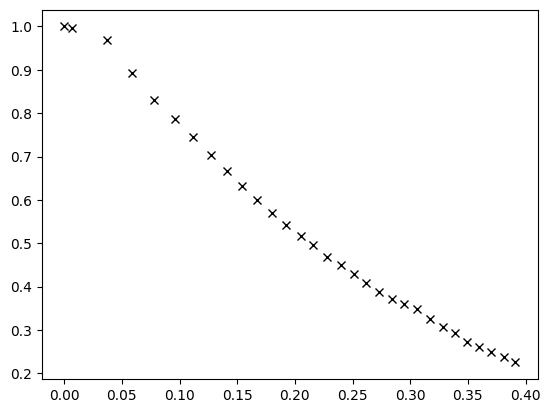

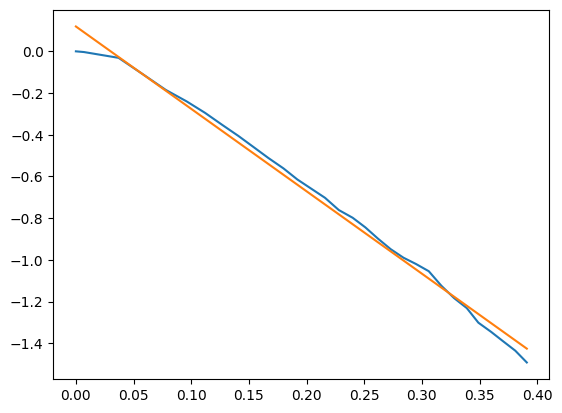

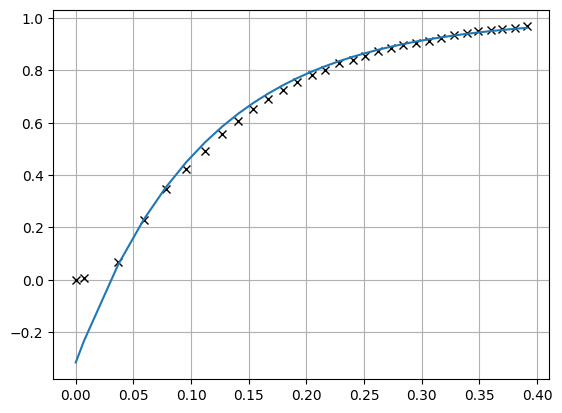

In [148]:
step = step_normalized
y_inf = 1

# Slowest component 1
step['Y_1'] = step.apply( lambda row : np.log10( y_inf - row.RPM ), axis = 1 )
fig,ax = plt.subplots()
ax.plot(step['T'], np.exp(step['Y_1']), 'kx');

fig2, ax2 = plt.subplots()
ax2.plot(step['T'], step['Y_1'])

# Linear regression
X = step['T'].to_numpy().reshape(-1,1)
Y = step['Y_1'].to_numpy()

reg = LinearRegression().fit(X,Y)
prediction = reg.predict(X)

ax2.plot(X, prediction)

A = -10**reg.intercept_
alpha = reg.coef_ / 0.4343

print(A)
print(alpha)

fig,ax = plt.subplots()
ax.plot(step['T'], step['RPM'], 'kx');
ax.grid(True)
ax.plot(X, y_inf + A*np.exp(alpha*X))

/tmp/ipykernel_14265/962120527.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  step2['Y_2'] = step2.apply( lambda row :  np.log10( abs( row.RPM - ( 1 + A*np.exp(alpha*row['T'])))), axis = 1 )


0.12695646122255214
[-38.12749522]


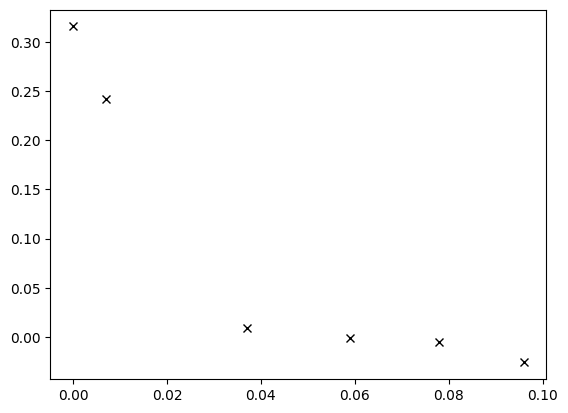

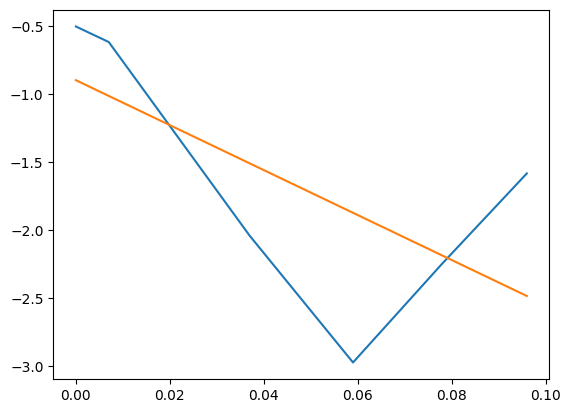

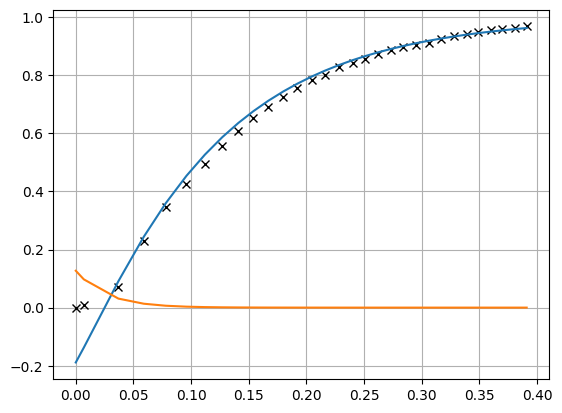

In [157]:
# Second slowest component
step2 = step[ step['T'] < 0.1]

step2['Y_2'] = step2.apply( lambda row :  np.log10( abs( row.RPM - ( 1 + A*np.exp(alpha*row['T'])))), axis = 1 )
fig,ax = plt.subplots()
ax.plot(step2['T'], (step2.RPM - ( 1 + A*np.exp(alpha*step2['T']))), 'kx');

fig2, ax2 = plt.subplots()
ax2.plot(step2['T'], step2['Y_2'])

# Linear regression
X = step2['T'].to_numpy().reshape(-1,1)
Y = step2['Y_2'].to_numpy()

reg = LinearRegression().fit(X,Y)
prediction = reg.predict(X)

ax2.plot(X, prediction)

B = 10**reg.intercept_ 
beta = reg.coef_ / 0.4343

print(B)
print(beta)

T = step['T'].to_numpy().reshape(-1,1)
fig,ax = plt.subplots()
ax.plot(step['T'], step['RPM'], 'kx');
ax.grid(True)
ax.plot(T, y_inf + A*np.exp(alpha*T) + B*np.exp(beta*T))
ax.plot(T, B*np.exp(beta*T))

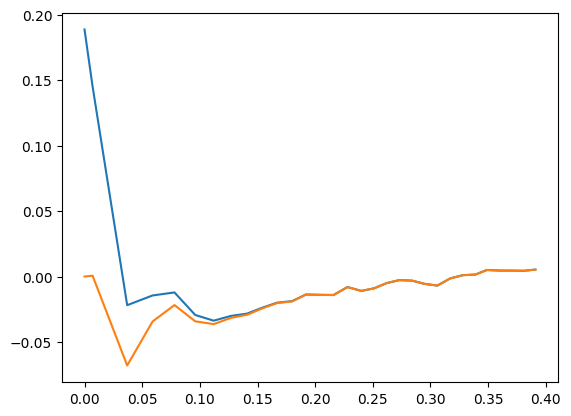

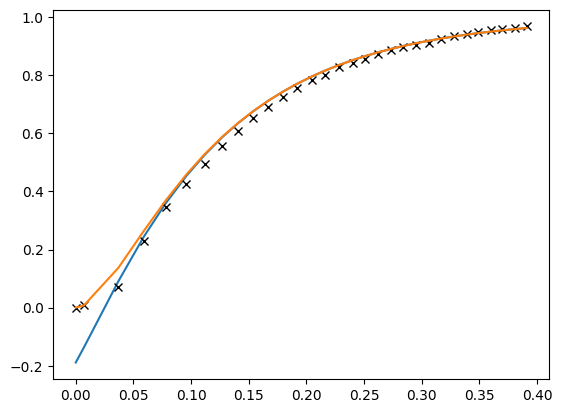

In [158]:
fig,ax = plt.subplots()
fig2,ax2 = plt.subplots()

Y = step['RPM'].to_numpy().reshape(-1,1)

ax.plot(T, Y- (y_inf + A*np.exp(alpha*T) + B*np.exp(beta*T)))
ax2.plot(T, (y_inf + A*np.exp(alpha*T) + B*np.exp(beta*T)))

B = -A-1
ax.plot(T, Y- (y_inf + A*np.exp(alpha*T) + B*np.exp(beta*T)))

ax2.plot(step['T'], step['RPM'], 'kx');
ax2.plot(T, (y_inf + A*np.exp(alpha*T) + B*np.exp(beta*T)))